In [34]:
import pandas as pd
import seaborn as sns

In [35]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import RobustScaler

In [36]:
# seaborn 한글 안깨지게
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

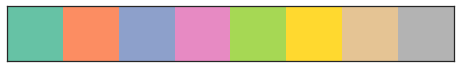

In [37]:
# seaborn palette -> 찾아보고 마음에 드는걸로 바꿔도 괜찮 !
palette = sns.color_palette('Set2') # palette 이름 () 안에 넣어주고
sns.palplot(palette) # 색상 확인
sns.set_palette('Set2') # 기본 palette로 적용됨

In [38]:
child=pd.read_csv("어린이인구.csv",encoding="cp949")

In [39]:
child=child[["행정동","어린이수"]]
child

,행정동,어린이수
0,가락1동,2054
1,가락2동,1819
2,가락본동,1045
3,가리봉동,167
4,가산동,423
...,...,...
419,효창동,498
420,후암동,653
421,휘경1동,518
422,휘경2동,879


## 어린이수 - 상권

In [40]:
market=pd.read_csv("행정동별_유통업체.csv",encoding="cp949")

In [41]:
# 중복 확인
market[market.duplicated(['행정동'])==True]

,행정동,유통업체수


In [42]:
child_market=pd.merge(child,market,on="행정동")
child_market

,행정동,어린이수,유통업체수
0,가락1동,2054,0
1,가락2동,1819,1
2,가락본동,1045,0
3,가리봉동,167,0
4,가산동,423,5
...,...,...,...
419,효창동,498,0
420,후암동,653,0
421,휘경1동,518,1
422,휘경2동,879,0


In [43]:
# 유통업체 0인 행정동 제거 (df_market)
df_market = child_market.drop(index = child_market[child_market['유통업체수']==0].index)
df_market = df_market.reset_index(drop=True)
df_market

,행정동,어린이수,유통업체수
0,가락2동,1819,1
1,가산동,423,5
2,가양2동,289,1
3,가양3동,410,1
4,갈현2동,1065,1
...,...,...,...
232,황학동,462,3
233,회기동,305,1
234,회현동,119,9
235,휘경1동,518,1


In [44]:
# scaling
scaler = RobustScaler()
df_market_scale=pd.DataFrame(scaler.fit_transform(df_market[['어린이수','유통업체수']]),columns=df_market[['어린이수','유통업체수']].columns)
df_market_scale.insert(0, '행정동', df_market['행정동'])
df_market_scale

,행정동,어린이수,유통업체수
0,가락2동,1.173913,0.0
1,가산동,-0.560248,4.0
2,가양2동,-0.726708,0.0
3,가양3동,-0.576398,0.0
4,갈현2동,0.237267,0.0
...,...,...,...
232,황학동,-0.511801,2.0
233,회기동,-0.706832,0.0
234,회현동,-0.937888,8.0
235,휘경1동,-0.442236,0.0


C:\Users\gtsye\anaconda3\envs\dongguk\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


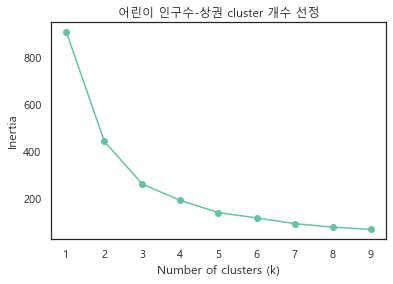

In [45]:
# elbow
data_market=df_market_scale.values
X=data_market[:,1:]
X
num_clusters = list(range(1,10))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(X)
    inertias.append(model.inertia_)

plt.title('어린이 인구수-상권 cluster 개수 선정')
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

k = 3 으로 선정

Text(0.5, 1.0, '어린이 인구수와 상권 clustering')

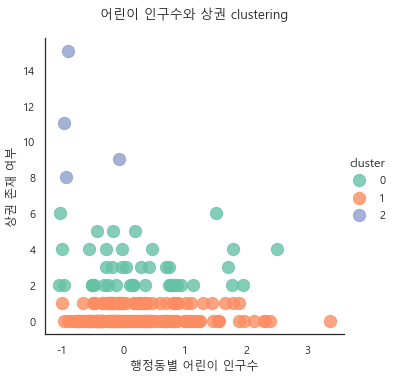

In [46]:
# clustering
kmeans = KMeans(n_clusters=3).fit(X)
kmeans.cluster_centers_
kmeans.labels_
df_market_scale['cluster'] = kmeans.labels_

sns.lmplot(x='어린이수',y='유통업체수', data = df_market_scale, fit_reg=False, scatter_kws={"s":150},hue="cluster")
plt.xlabel('행정동별 어린이 인구수')
plt.ylabel('상권 존재 여부')
plt.title('어린이 인구수와 상권 clustering', fontsize = 13, pad = 20) # pad : 제목과 그림 사이 간격

2번 cluster(상단) 선정

In [47]:
df_market['cluster'] = df_market_scale['cluster']
df_market[df_market['cluster']==2]

,행정동,어린이수,유통업체수,cluster
12,광희동,91,12,2
133,신당동,143,16,2
221,한강로동,818,10,2
234,회현동,119,9,2


해당 cluster에 어린이가 너무 적다는 문제 발견 <br>
scaling 된 어린이 값 > 0 을 이용해보기로 생각

In [48]:
df_market_scale

,행정동,어린이수,유통업체수,cluster
0,가락2동,1.173913,0.0,1
1,가산동,-0.560248,4.0,0
2,가양2동,-0.726708,0.0,1
3,가양3동,-0.576398,0.0,1
4,갈현2동,0.237267,0.0,1
...,...,...,...,...
232,황학동,-0.511801,2.0,0
233,회기동,-0.706832,0.0,1
234,회현동,-0.937888,8.0,2
235,휘경1동,-0.442236,0.0,1


In [49]:
df_market_scale_0 = df_market_scale[df_market_scale['어린이수']>0]
df_market_scale_0 = df_market_scale_0.reset_index(drop=True)
df_market_scale_0

,행정동,어린이수,유통업체수,cluster
0,가락2동,1.173913,0.0,1
1,갈현2동,0.237267,0.0,1
2,개봉2동,0.685714,0.0,1
3,고척2동,0.397516,0.0,1
4,공덕동,0.776398,2.0,0
...,...,...,...,...
113,행당2동,0.386335,1.0,1
114,홍은1동,0.104348,0.0,1
115,화곡1동,0.869565,2.0,0
116,화곡3동,0.012422,0.0,1


C:\Users\gtsye\anaconda3\envs\dongguk\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


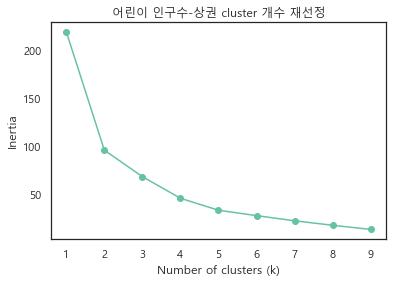

In [50]:
# elbow
data = df_market_scale_0.values
X=data[:,1:-1]

num_clusters = list(range(1,10))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(X)
    inertias.append(model.inertia_)

plt.title('어린이 인구수-상권 cluster 개수 재선정')
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

k = 4 으로 선정

Text(0.5, 1.0, '어린이 인구수와 상권 2차 clustering')

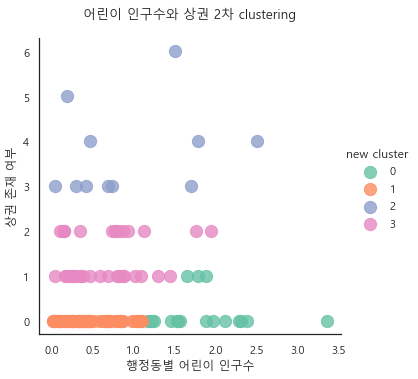

In [53]:
# clustering
kmeans = KMeans(n_clusters=4).fit(X)
kmeans.cluster_centers_
kmeans.labels_
df_market_scale_0['new cluster'] = kmeans.labels_

sns.lmplot(x='어린이수',y='유통업체수', data = df_market_scale_0, fit_reg=False, scatter_kws={"s":150},hue="new cluster")
plt.xlabel('행정동별 어린이 인구수')
plt.ylabel('상권 존재 여부')
plt.title('어린이 인구수와 상권 2차 clustering', fontsize = 13, pad = 20) # pad : 제목과 그림 사이 간격

In [54]:
result = df_market_scale_0[df_market_scale_0['new cluster']==2]
result

,행정동,어린이수,유통업체수,cluster,new cluster
8,구로5동,0.295652,3.0,0,2
10,구의3동,0.464596,4.0,0,2
13,길음1동,2.509317,4.0,0,2
23,독산1동,1.504348,6.0,0,2
33,문래동,1.708075,3.0,0,2
72,압구정동,0.742857,3.0,0,2
84,용신동,0.040994,3.0,0,2
95,잠실3동,1.790062,4.0,0,2
96,잠실6동,0.193789,5.0,0,2
100,전농1동,0.417391,3.0,0,2


In [55]:
result.to_csv("어린이인구수_상권_clustering.csv",encoding="cp949")